# 1. Análisis exploratorio de WelFake
Autor: Inmaculada García Moreno 


Este notebook analiza los títulos de noticias reales y falsas, usando procesamiento de texto y visualización de las palabras más frecuentes.

### Importación de librerías

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import sys
sys.path.append('../src')  # Añades esa carpeta al path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
nltk.download('stopwords')
nltk.download('punkt', download_dir='/home/inma/nltk_data')
nltk.download('punkt_tab')
from utils import *


[nltk_data] Downloading package stopwords to /home/inma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/inma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/inma/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Carga y etiquetado de datos

In [3]:
# Ruta a los datos 
path = '../data/raw/WELFake_Dataset.csv' 

# Cargar CSVs
df = load_data_all(path)

In [4]:
df.shape

(71537, 7)

In [5]:
df.head(5)

,Unnamed: 0,title,text,label,news_type,title_length,sentences
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...


In [6]:
df['news_type'].value_counts()

news_type
Real     36509
Falsa    35028
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    71537 non-null  int64 
 1   title         71537 non-null  object
 2   text          71537 non-null  object
 3   label         71537 non-null  int64 
 4   news_type     71537 non-null  object
 5   title_length  71537 non-null  int64 
 6   sentences     71537 non-null  object
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


In [8]:
df.describe()

,Unnamed: 0,label,title_length
count,71537.000000,71537.000000,71537.000000
mean,36045.667599,0.510351,77.130240
std,20826.109542,0.499896,25.028377
min,0.000000,0.000000,1.000000
25%,18000.000000,0.000000,62.000000
50%,36035.000000,1.000000,73.000000
75%,54083.000000,1.000000,89.000000
max,72133.000000,1.000000,456.000000


### Limpieza de datos
Como hay algunas noticias que se han colado y no estan en ingles, las determinamos

In [9]:
df.isnull().sum()

Unnamed: 0      0
title           0
text            0
label           0
news_type       0
title_length    0
sentences       0
dtype: int64

In [10]:
import re

def preprocess_for_langdetect(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+", "", text)        # elimina URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)     # elimina símbolos, números, etc.
    text = re.sub(r"\s+", " ", text).strip()    # normaliza espacios
    return text

df['sentences_clean'] = df['sentences'].apply(preprocess_for_langdetect)

In [11]:
from langdetect import detect


def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"

df['lang'] = df['sentences_clean'].apply(detect_lang)
df['lang'].value_counts()

lang
en       71068
es         146
de          89
error       51
fr          39
sl          20
ca          17
hr          16
pt          10
it           9
ro           8
no           7
tr           7
af           7
nl           5
lv           5
hu           4
pl           4
da           4
sv           4
tl           3
cy           3
et           3
so           3
sw           1
sk           1
vi           1
id           1
fi           1
Name: count, dtype: int64

In [13]:
df[df['lang'] == 'error']

,Unnamed: 0,title,text,label,news_type,title_length,sentences,sentences_clean,lang
401,401,Чем закончатся изменения региональной динамики...,Как отмечает в своей новой статье ветеран боев...,1,Real,93,Чем закончатся изменения региональной динамики...,,error
795,795,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,1,Real,66,https://fedup.wpengine.com/wp-content/uploads/...,,error
3605,3605,В России могут ввести налог на депозиты?,0 комментариев \nОдним из вариантов пополнен...,1,Real,40,В России могут ввести налог на депозиты? 0 ком...,,error
4057,4057,Казахстан на страже ядерной безопасности | Нов...,В ноябре 2016 г. Мажилис Парламента Республики...,1,Real,68,Казахстан на страже ядерной безопасности | Нов...,,error
4476,4476,Щит Евфрата: удастся ли замысел Вашингтона? | ...,Страна: Сирия В своей новой статье постоянный ...,1,Real,71,Щит Евфрата: удастся ли замысел Вашингтона? | ...,,error
5881,5881,"Путин: Не думаю, что агрессивность - мой стиль","0 комментариев 18 поделились \n""Уважаемый моде...",1,Real,46,"Путин: Не думаю, что агрессивность - мой стиль...",,error
8909,8909,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,1,Real,74,https://fedup.wpengine.com/wp-content/uploads/...,,error
12186,12186,Как «троцкисты» осаждали российское посольство...,Регион: Европа Как отмечает в своей статье аме...,1,Real,90,Как «троцкисты» осаждали российское посольство...,,error
13222,13222,Стоит ли ожидать конца войны в Сирии? | Новое ...,Страна: Сирия В своей новой статье постоянный ...,1,Real,65,Стоит ли ожидать конца войны в Сирии? | Новое ...,,error
14238,14238,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,1,Real,74,https://fedup.wpengine.com/wp-content/uploads/...,,error


In [14]:
df = df[df['lang'] == 'en']

In [15]:

df.to_csv("../data/processed/WELFake_only_english.csv", index=False)


In [16]:
df.head(2)

,Unnamed: 0,title,text,label,news_type,title_length,sentences,sentences_clean,lang
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement on high alert following threat...,en
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general says most...,en


In [3]:
df = pd.read_csv("../data/processed/WELFake_only_english.csv")
df.drop(columns=['Unnamed: 0', 'sentences_clean'], inplace=True)
df.shape

(71068, 7)

El conjunto de datos no contiene valores nulos en las columnas text y news_type, que son las más importantes para nosotros.  

### EDA

## Preprocesamiento del texto

Definimos una función de preprocesamiento que realiza las siguientes operaciones:

- Conversión del texto a minúsculas

- Eliminación de números del corpus de texto

- Eliminación de signos de puntuación del corpus de texto

- Eliminación de caracteres especiales como ‘<’, ‘…’ del corpus de texto

- Eliminación de palabras vacías en inglés (stopwords)

- Reducción de las palabras a su raíz (stemming)

- Eliminación de espacios en blanco adicionales del corpus de texto

In [4]:
ps = PorterStemmer()
wst = WhitespaceTokenizer()
stop_words = set(stopwords.words('english'))


def final(text):
    # 1. Minúsculas
    text = text.lower()

    # 2. Tokenización por espacios
    tokens = wst.tokenize(text)

    # 3. Limpiar y filtrar tokens
    clean = []
    for token in tokens:
        # Eliminar números y puntuación y símbolos raros en los tokens
        token = ''.join(c for c in token if c.isalpha())
        if token and token not in stop_words:
            stemmed = ps.stem(token)
            clean.append(stemmed)

    return clean  # ← lista de tokens limpia




### Análisis de las palabras más frecuentes en los títulos de noticias reales y falsas

En este bloque de código se realiza un análisis exploratorio del texto contenido en los **títulos de las noticias**, con el objetivo de identificar las palabras más frecuentes en cada categoría (`Falsa` y `Real`).

#### 1. Noticias falsas (`Falsa`)
- Se filtra el conjunto de datos para quedarnos solo con las noticias clasificadas como falsas.
- Se aplica la función `final` (función de preprocesamiento definida previamente) a los títulos utilizando `CountVectorizer`, que genera una representación Bag of Words.
- Se transforma el resultado en una matriz densa (DataFrame) donde:
  - Las filas representan noticias.
  - Las columnas representan palabras únicas.
- Se obtiene la frecuencia total de cada palabra (suma de cada columna) y se seleccionan las 20 palabras más frecuentes.


In [5]:
# Filtramos solo las noticias falsas
df_fake = df[df['news_type'] == 'Falsa']
df_fake.shape

(35026, 7)

In [6]:


# Creamos un vectorizador que utiliza la función 'final' para preprocesar los títulos
cv1 = CountVectorizer(analyzer=final)

# Ajustamos el vectorizador a los títulos de noticias falsas
cv1.fit(df_fake['title'])

# Transformamos los títulos en una matriz Bag of Words (sparse matrix)
bow1 = cv1.transform(df_fake['title'])

# Comprobamos la forma de la matriz: 
shape=pd.DataFrame(bow1.todense()).shape
shape

(35026, 15132)

In [7]:
# 1) Suma de frecuencias por palabra (columna) sobre la matriz sparse
#    bow1: scipy.sparse matrix (n_docs × n_features)
freqs = bow1.sum(axis=0).A1           # array shape (n_features,)

# 2) Nombres de las palabras
words = cv1.get_feature_names_out()   # array shape (n_features,)

# 3) Montar un DataFrame ligero con todas las frecuencias
df_freq = pd.DataFrame({
    'word': words,
    'sum' : freqs
})

# 4) Seleccionar las 20 más frecuentes
top1 = df_freq.nlargest(20, 'sum').reset_index(drop=True)

#### 2. Noticias reales (`Real`)
- Se repite exactamente el mismo proceso anterior, pero ahora para los títulos de noticias reales.
- Se genera un segundo conjunto con las 20 palabras más frecuentes en esta categoría.

In [8]:
df_real = df[df['news_type'] == 'Real']
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2 = cv2.transform(df_real['title'])
shape=pd.DataFrame(bow2.todense()).shape  
shape

(36042, 17667)

In [9]:
# 1) Suma de frecuencias por palabra (columna) sobre la matriz sparse
#    bow2: scipy.sparse matrix (n_docs × n_features)
freqs = bow2.sum(axis=0).A1           # array shape (n_features,)

# 2) Nombres de las palabras
words = cv2.get_feature_names_out()   # array shape (n_features,)

# 3) Montar un DataFrame ligero con todas las frecuencias
df_freq = pd.DataFrame({
    'word': words,
    'sum' : freqs
})

# 4) Seleccionar las 20 más frecuentes
top2 = df_freq.nlargest(20, 'sum').reset_index(drop=True)

#### 3. Concatenación de resultados
- Se eliminan las columnas originales de conteo de palabras (filas de artículos).
- Se añade una columna `type` que indica si el conjunto de palabras pertenece a noticias `Falsa` o `Real`.
- Se concatenan ambos DataFrames (`top1` y `top2`) para tener una única tabla con las 40 palabras más frecuentes (20 por clase).

In [10]:

top1['type'] = ['Falsa'] * 20  # Añadimos columna que indica que son noticias falsas

top2['type'] = ['Real'] * 20  # Añadimos columna que indica que son noticias reales

# Unimos ambos DataFrames
conc1 = pd.concat([top1, top2])
conc1.shape

(40, 3)

#### 4. Visualización
- Se genera un gráfico de barras horizontal con `seaborn` que muestra:
  - Las palabras más frecuentes en los títulos.
  - Su frecuencia total.
  - Su tipo de noticia (`Falsa` o `Real`) mediante el color.

Este análisis nos permite observar patrones léxicos diferenciales entre los titulares de noticias verdaderas y falsas, lo que puede servir como base para entender el comportamiento del lenguaje en cada caso, y justificar la utilidad de los títulos como variable de entrada para modelos de clasificación.


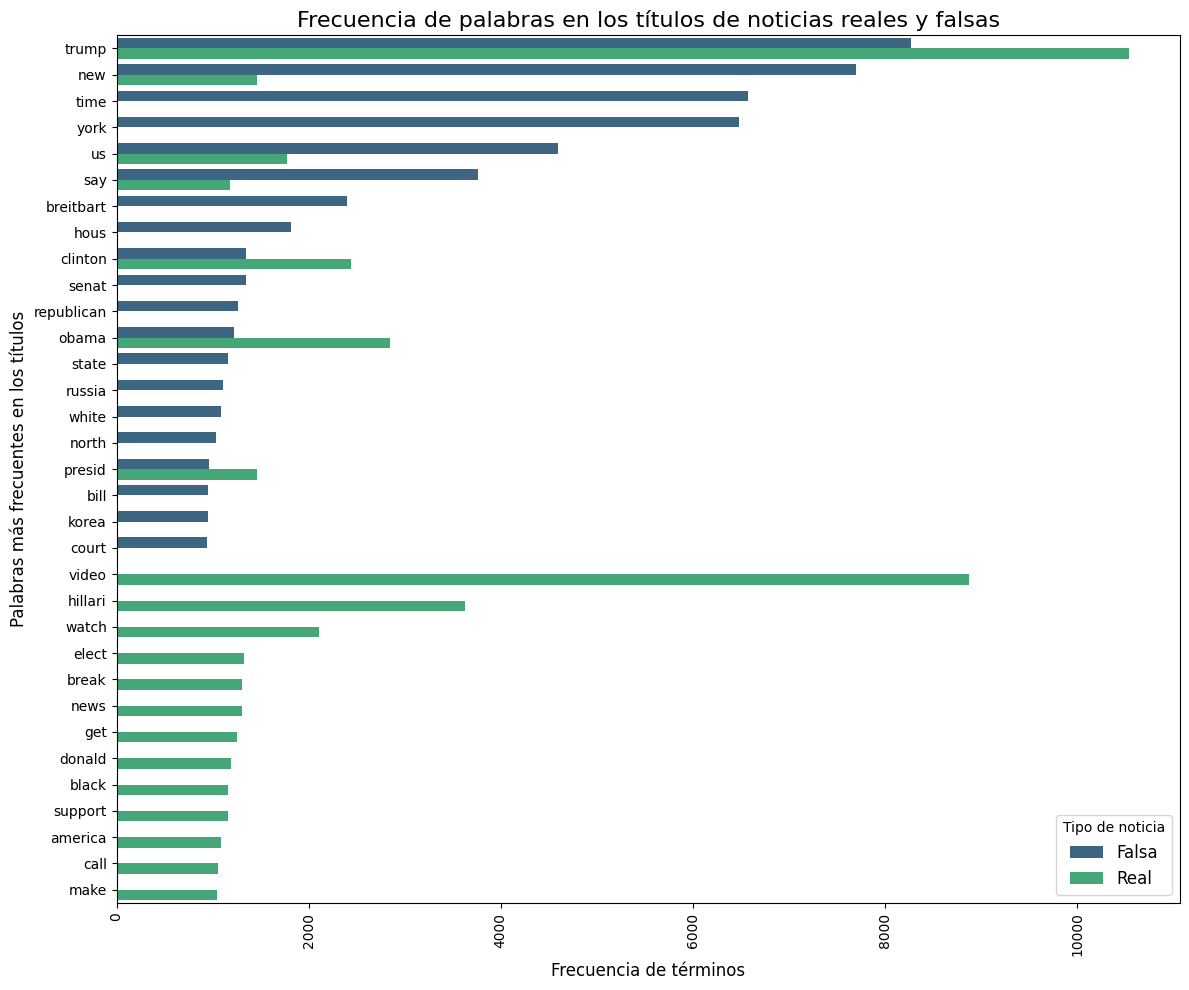

In [11]:
plt.figure(figsize=(12, 10))
sns.barplot(
    data=conc1,
    y='word',
    x='sum',
    hue='type',
    palette='viridis'
)
plt.xticks(rotation=90)
plt.xlabel('Frecuencia de términos', fontsize=12)
plt.ylabel('Palabras más frecuentes en los títulos', fontsize=12)
plt.legend(title='Tipo de noticia', fontsize=12)
plt.title('Frecuencia de palabras en los títulos de noticias reales y falsas', fontsize=16)
plt.tight_layout()
plt.show()


El gráfico de frecuencia de términos muestra que algunas palabras como trump, new york y clinton son representativas de los títulos de noticias falsas, mientras que palabras como trump, clinton, obama y presidente son representativas de los títulos de noticias reales.

## Análisis del cuerpo de las noticias
Después de analizar el título, analizamos el cuerpo del texto de los artículos de noticias. Nos interesa encontrar las 30 palabras más representativas en el cuerpo de noticias falsas y reales. Realizamos los mismos pasos aplicando la función final al cuerpo del artículo, y luego seleccionamos las 30 palabras más frecuentes en ambas categorías, es decir, noticias reales y noticias falsas. Representamos gráficamente la frecuencia de dichos términos para visualizar las palabras de alta frecuencia asociadas con noticias falsas y reales.

In [26]:
# Noticias falsas
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [27]:
# 1) Suma de frecuencias por palabra (columna) sobre la matriz sparse
#    bow1: scipy.sparse matrix (n_docs × n_features)
freqs = bow3.sum(axis=0).A1           # array shape (n_features,)

# 2) Nombres de las palabras
words = cv3.get_feature_names_out()   # array shape (n_features,)

# 3) Montar un DataFrame ligero con todas las frecuencias
df_freq = pd.DataFrame({
    'word': words,
    'sum' : freqs
})

# 4) Seleccionar las 20 más frecuentes
top3 = df_freq.nlargest(30, 'sum').reset_index(drop=True)

In [28]:
#Noticias verdaderas
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])

In [29]:
# 1) Suma de frecuencias por palabra (columna) sobre la matriz sparse
#    bow1: scipy.sparse matrix (n_docs × n_features)
freqs = bow4.sum(axis=0).A1           # array shape (n_features,)

# 2) Nombres de las palabras
words = cv4.get_feature_names_out()   # array shape (n_features,)

# 3) Montar un DataFrame ligero con todas las frecuencias
df_freq = pd.DataFrame({
    'word': words,
    'sum' : freqs
})

# 4) Seleccionar las 20 más frecuentes
top4 = df_freq.nlargest(30, 'sum').reset_index(drop=True)

In [30]:
# Concatenación
top3['type']=['Falsa']*30
top4['type']=['Real']*30
conc2=pd.concat([top3,top4])

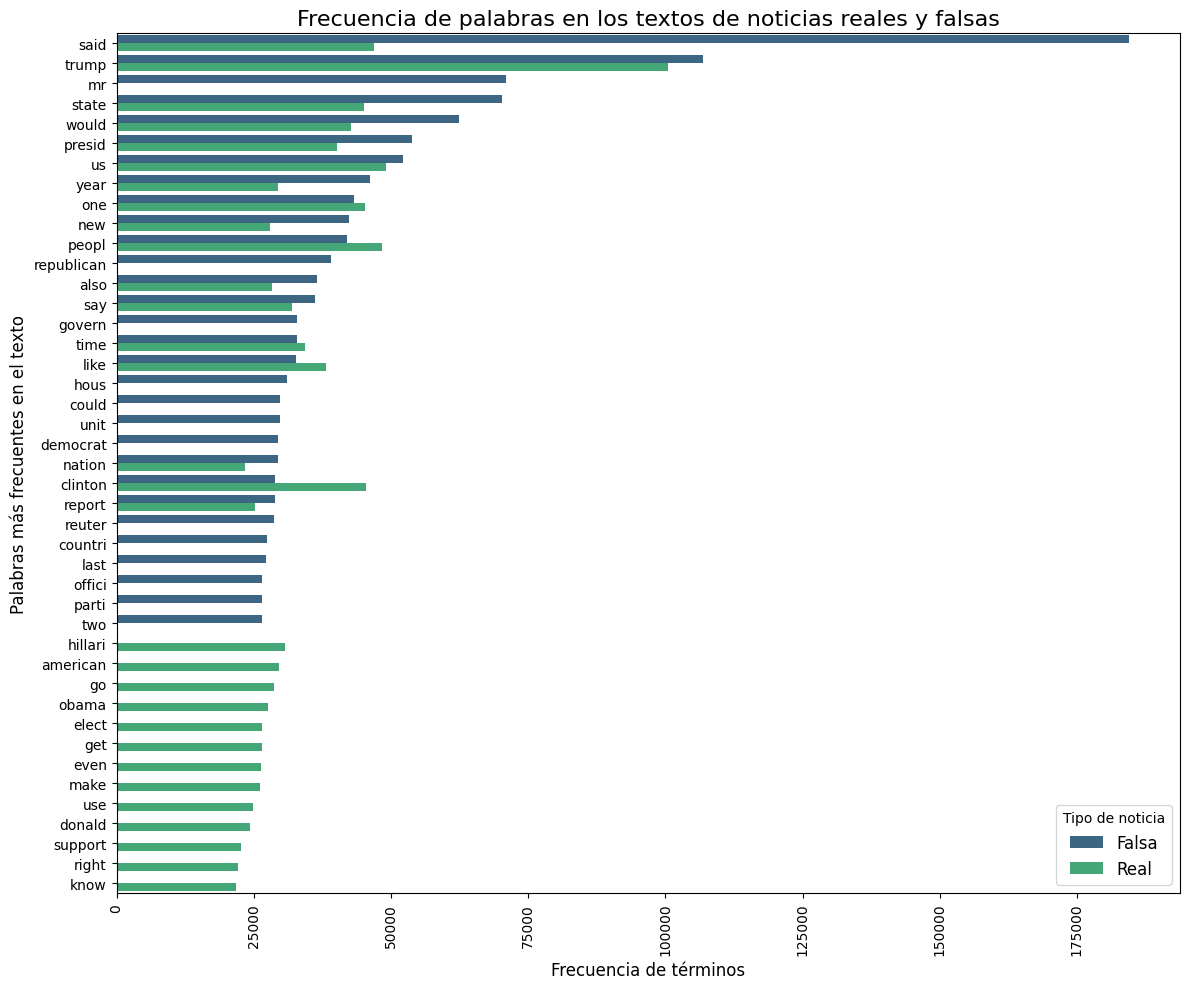

In [31]:
plt.figure(figsize=(12, 10))
sns.barplot(
    data=conc2,
    y='word',
    x='sum',
    hue='type',
    palette='viridis'
)
plt.xticks(rotation=90)
plt.xlabel('Frecuencia de términos', fontsize=12)
plt.ylabel('Palabras más frecuentes en el texto', fontsize=12)
plt.legend(title='Tipo de noticia', fontsize=12)
plt.title('Frecuencia de palabras en los textos de noticias reales y falsas', fontsize=16)
plt.tight_layout()
plt.show()

A partir del gráfico anterior, observamos que palabras como trump y clinton son las más frecuentes en el cuerpo de las noticias. El gráfico de frecuencia de términos muestra que algunas palabras como said, state y trump son representativas de las noticias falsas.

## Análisis de la longitud del título
Después del análisis de las palabras en el título y en el cuerpo de las noticias, queremos saber si la longitud del título también es una característica o factor discriminante entre las categorías de noticias falsas y reales.

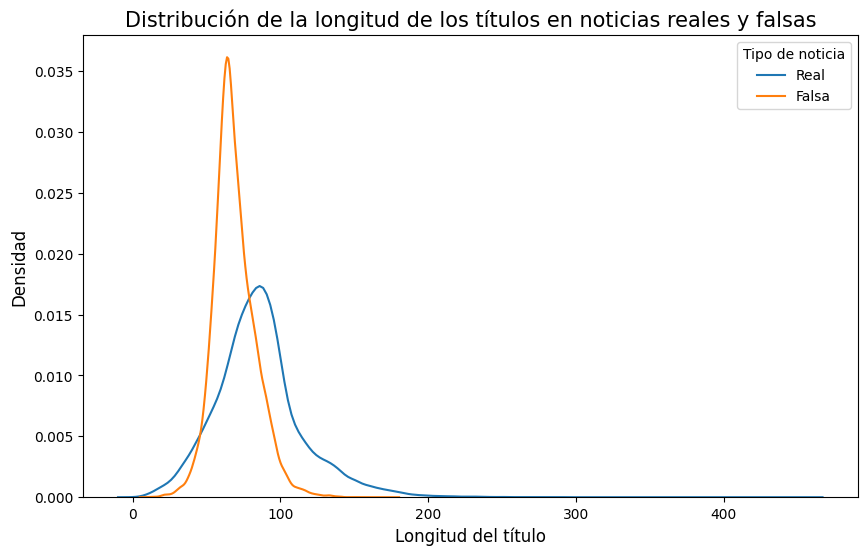

In [32]:
# Crea una nueva columna con la longitud de cada título
df['title_length'] = df['title'].apply(lambda x: len(x))

plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['title_length'])
sns.kdeplot(df[df['news_type']=='Falsa']['title_length'])
plt.xlabel('Longitud del título', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Tipo de noticia', fontsize=10, labels=['Real','Falsa'])
plt.title('Distribución de la longitud de los títulos en noticias reales y falsas', fontsize=15)
plt.show()



La longitud del título en las noticias falsas es ligeramente mayor que en las noticias reales. 

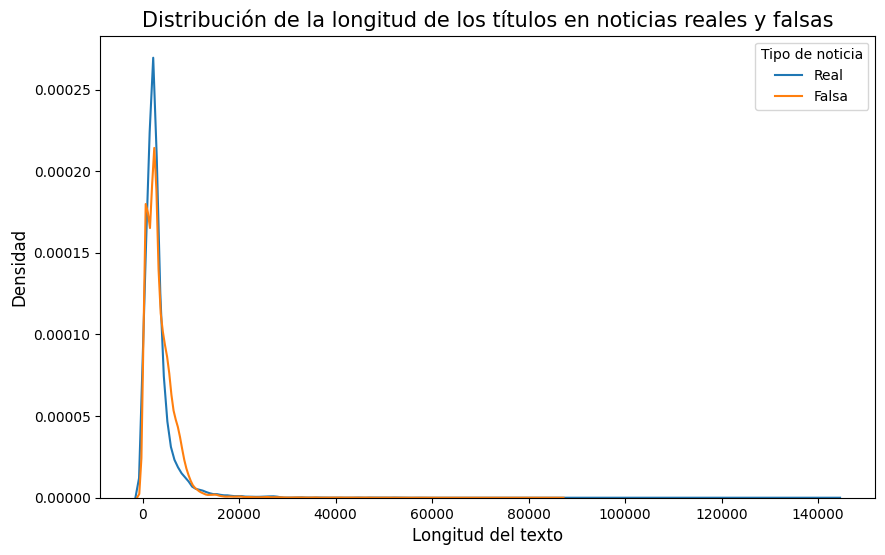

In [ ]:
# Crea una nueva columna con la longitud de cada título
df['length'] = df['sentences'].apply(lambda x: len(x))

plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['length'])
sns.kdeplot(df[df['news_type']=='Falsa']['length'])
plt.xlabel('Longitud del texto', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Tipo de noticia', fontsize=10, labels=['Real','Falsa'])
plt.title('Distribución de la longitud del texto en noticias reales y falsas', fontsize=15)
plt.show()

In [34]:
df[df['title_length'] < 10]

,title,text,label,news_type,title_length,sentences,lang,length
6280,Wow!,http://www.thepoliticalinsider.com/wikileaks-c...,1,Real,4,Wow! http://www.thepoliticalinsider.com/wikile...,en,1219
11339,Tweetwave,This time it's true no pantsTweetwave More Of ...,1,Real,9,Tweetwave This time it's true no pantsTweetwav...,en,27550
19973,Wikileaks,"Whales, elephants of the deep with fins the si...",1,Real,9,"Wikileaks Whales, elephants of the deep with f...",en,1056
26959,EPIC,It didn’t take us long to think of a word to d...,1,Real,4,EPIC It didn’t take us long to think of a word...,en,2125
27934,Rick Rule,"97925 Views October 29, 2016 BROADCAST King Wo...",1,Real,9,"Rick Rule 97925 Views October 29, 2016 BROADCA...",en,3969
28804,What If….,"all 30,000 of the “missing” Hillary emails are...",1,Real,9,"What If…. all 30,000 of the “missing” Hillary ...",en,6081
30788,Ooh Fuck,Wednesday 9 November 2016 by Lucas Wilde Ooh F...,1,Real,8,Ooh Fuck Wednesday 9 November 2016 by Lucas Wi...,en,1332
30896,Rum,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,1,Real,3,Rum RIGHT REVERAND POPE JEREMIAH GOLDSTIEN say...,en,426
32893,What Now?,by Thomas Sowell \nThe good news is that we do...,1,Real,9,What Now? by Thomas Sowell \nThe good news is ...,en,4719
33864,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,1,Real,8,Homepage [vc_row][vc_column width= 1/1 ][td_bl...,en,587


In [35]:
df = df.drop_duplicates(subset='title', keep='first')
df.shape


(61856, 8)

In [36]:
df

,title,text,label,news_type,title_length,sentences,lang,length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,en,5180
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,en,354
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri...",en,8116
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...,en,2012
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...,en,1609
...,...,...,...,...,...,...,...,...
71061,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,Real,104,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,en,1342
71063,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Falsa,65,Russians steal research on Trump in hack of U....,en,4854
71064,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,Real,79,WATCH: Giuliani Demands That Democrats Apolog...,en,3714
71065,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Falsa,57,Migrants Refuse To Leave Train At Refugee Camp...,en,2922


Mostramos una nube de palabras 

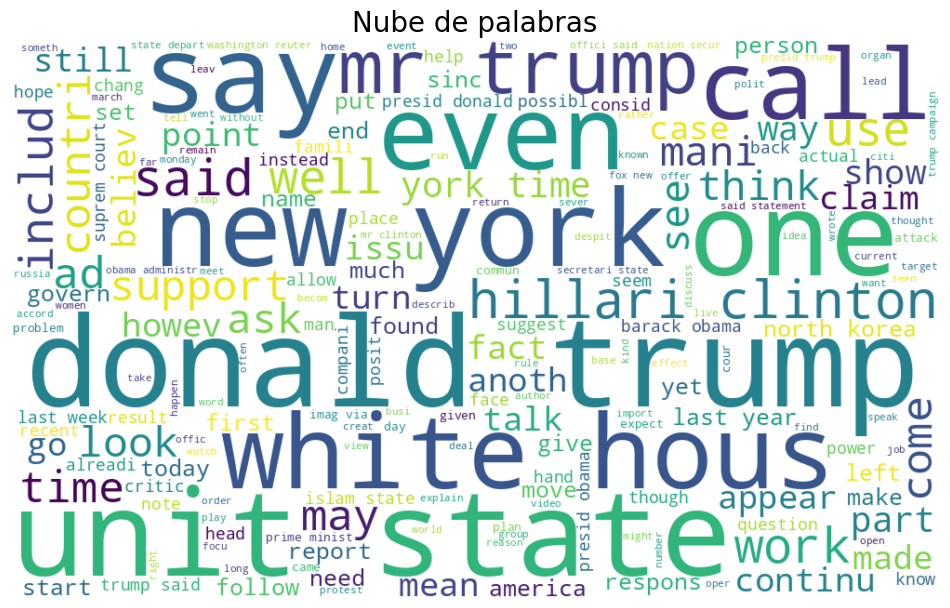

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus textos limpios en una columna
# Puedes usar una sola cadena uniendo todo
text = " ".join([" ".join(tokens) for tokens in df['sentences'].apply(final)])

# Crear el objeto WordCloud
wc = WordCloud(width=1000, height=600, background_color='white', colormap='viridis').generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras", fontsize=20)
plt.show()